# Deep Reinforcement Learning in Action
### by Alex Zai and Brandon Brown

#### Chapter 4

##### Supplemental

In [1]:
from matplotlib import pyplot as plt

def moving_average(x,step=5,window=50):
    num = (x.shape[0] - window) / step
    num = int(num)
    avg = np.zeros(num)
    slider = np.ones(window) / window
    start = 0
    for i in range(num):
        end = start + window
        avg[i] = slider @ x[start:end]
        start = start + step
    return avg

##### Listing 4.1

In [2]:
from gym import envs
#envs.registry.all()

##### Listing 4.2

In [3]:
import gym
env = gym.make('CartPole-v0')

##### Listing 4.3

In [4]:
state1 = env.reset()
action = env.action_space.sample()
state, reward, done, info = env.step(action)

##### Listing 4.4

In [5]:
import gym
import numpy as np
import torch
 
l1 = 4
l2 = 150
l3 = 2
 
model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.Softmax(dim=0)
)
 
learning_rate = 0.009
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

##### Listing 4.5

In [6]:
pred = model(torch.from_numpy(state1).float())
action = np.random.choice(np.array([0,1]), p=pred.data.numpy())
state2, reward, done, info = env.step(action)

##### Listing 4.6

In [7]:
def discount_rewards(rewards, gamma=0.99):
    lenr = len(rewards)
    disc_return = torch.pow(gamma,torch.arange(lenr).float()) * rewards
    disc_return /= disc_return.max()
    return disc_return

##### Listing 4.7

In [8]:
def loss_fn(preds, r):
    return -1 * torch.sum(r * torch.log(preds))

##### Listing 4.8

In [9]:
MAX_DUR = 200
MAX_EPISODES = 500
gamma = 0.99
score = []
for episode in range(MAX_EPISODES):
        curr_state = env.reset()
        done = False
        transitions = []

        for t in range(MAX_DUR):
            act_prob = model(torch.from_numpy(curr_state).float())
            action = np.random.choice(np.array([0,1]), p=act_prob.data.numpy())
            prev_state = curr_state
            curr_state, _, done, info = env.step(action)
            transitions.append((prev_state, action, t+1))
            if done:
                break
 
        ep_len = len(transitions)
        score.append(ep_len)
        reward_batch = torch.Tensor([r for (s,a,r) in
        transitions]).flip(dims=(0,))
        disc_rewards = discount_rewards(reward_batch)
        state_batch = torch.Tensor([s for (s,a,r) in transitions])
        action_batch = torch.Tensor([a for (s,a,r) in transitions])
        pred_batch = model(state_batch)
        prob_batch = pred_batch.gather(dim=1,index=action_batch.long().view(-1,1)).squeeze()
        loss = loss_fn(prob_batch, disc_rewards)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

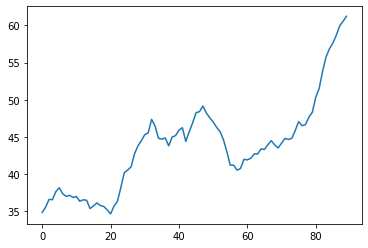

In [10]:
plt.plot(moving_average(np.array(score)))